## Домашнее задание - 6


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
!pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [3]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


In [6]:
recommender.get_als_recommendations(2375, N=5)

[1106523, 899624, 871756, 1044078, 1000753]

In [7]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [8]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 844179, 842125, 5568378]

In [9]:
recommender.get_similar_users_recommendation(2375, N=5)

[9677454, 1012801, 6979437, 857540, 12523928]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
users_cold = np.setdiff1d(result_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()
users_cold

[296, 1813, 1984]

In [12]:
result_lvl_1 = result_lvl_1[~result_lvl_1['user_id'].isin(users_cold)]

In [13]:
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [14]:
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))
result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual']), axis=1).mean()

0.018201887674891032

In [15]:
result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))
result_lvl_1.apply(lambda row: recall_at_k(row['als_recommendations'], row['actual']), axis=1).mean()

0.0139981438568441

In [16]:
result_lvl_1['similar_items_recommendation'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=200))
result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recommendation'], row['actual']), axis=1).mean()

0.006231662149455495

In [17]:
result_lvl_1.head(2)

,user_id,actual,own_recommendations,als_recommendations,similar_items_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1037332, 1120261, 856942, 8293439, 5577022, 8...","[926763, 1007512, 9297615, 5577022, 9803207, 9..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 978332, 834399, 996087, 865528, 9100...","[8090509, 5569845, 1044078, 985999, 880888, 81..."


In [18]:
k_list = [20, 50, 100, 200, 500]
rec = result_lvl_1.columns.drop(['user_id','actual'])
recall_k_df = pd.DataFrame(index=k_list, columns=rec)

for r in rec:
    for k in k_list:
        recall_value = result_lvl_1.apply(lambda row: recall_at_k(row[r], row['actual'], k=k), axis=1).mean()
        recall_k_df.loc[k, r] = recall_value

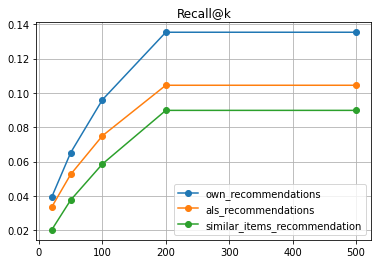

In [19]:
recall_k_df.plot(marker='o')
plt.title('Recall@k')
plt.grid(True)
plt.show()

*   Наибольший *recall@k* даёт *own recommendtions+top-popular*;
*   По мере увеличения *k* наблюдается увеличение *recall@k*, до числа равного максимальному числу кандидатов;
*   Наиболее целесообразным значением *k* является значение равное максимальному числу кандидатов, в нашем случае k=200.



### Задание 2.

Обучите модель 2-ого уровня, при этом:
    
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар;
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2;
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [20]:
als_recommendations = result_lvl_1[['user_id', 'als_recommendations']]

In [21]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})
valid_lvl_2 = valid_lvl_2.merge(als_recommendations, on='user_id', how='left')

In [22]:
valid_lvl_2[valid_lvl_2.als_recommendations.notna()].\
apply(lambda row: precision_at_k(row['als_recommendations'], row['actual'], k=5), axis=1).mean()

0.10673629242819796